In [1]:
# imports
import numpy as np
from matplotlib import pyplot as plt
from colour import Color

In [2]:
plt.rcParams['figure.figsize'] = [9,9]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

# colours
red = '#EA2027'
blue = '#0652DD'
green = '#009432'

# Input constants and rider metrics

In [3]:
m = 65 + 15 # total weight - bike + rider + faff (kg)
G = 0 # % gradient of road as a decimal (0-1)

CdA = 0.4 # Coefficient of drag * frontal area
n = 0.96 # % drive train efficiency as a decimal (0-1)
# see https://ridefar.info/bike/cycling-speed/mechanical-resistance/
Crr = 0.00606 # Coefficient of rolling resistance - current value for conti-gatorskins
# see https://www.bicyclerollingresistance.com/road-bike-reviews/continental-gatorskin-2015 

h = 0 # height of the road (m)
T = 273+20 # Temperature (K)

g = 9.81 # (ms^-2)
L = 0.0065 # (Km^-1)
T0 = 298 # (K)
M = 0.02896 # (kg mol^-1)
Rs = 287.058 # (J kg^-1 K^-1)
p0 = 101325 # (Pa)
Ru = 8.31 # (J mol^-1 K_1)

# maybe add wind in a bit?
# v_w = 0 


# Mafs

$F_{air} = \frac{1}{2}C_dA\rho v^2$

$F_{roll} = C_{rr}N = C_{rr}mg\cos(\arctan(G))$

$F_{grav} = mg\sin(\arctan(G))$

$P = \boldsymbol{F} . \boldsymbol{v}$

$P_{legs} = (F_{air} + F_{roll} + F_{grav}) \times \frac{v}{n}$

$P_{legs} = \left(\frac{1}{2}C_dA\rho v^3 + C_{rr}mgv\cos(\arctan(G))+ mgv\sin(\arctan(G))\right) \frac{1}{n}$

Ignoring wind for now as thats faff

### Things that are confusing

Gradient $\% = \frac{\textrm{height gain}}{\textrm{climb length}}$

So $\% \neq \theta_{hill}$ and $50\% \neq 45^{\circ} $


# Functions

In [4]:
# air density at a given height (m) and temperature (K)
def rho(h, T):
    return (p0/(Rs * T)) * (1-((L*h)/T0))**((M*g)/(Ru*L))

# Force from air resistance
def F_air(v):
    return 0.5 * CdA * v**2 * rho(h, T)

# Force from rolling resistance
def F_roll(v, G):
    if type(v) != np.ndarray: # doing this so it will work for int, float and array input
        return Crr * m * g * (np.cos(np.arctan(G)))
    else:
        return np.full(len(v), Crr * m * g * np.cos(np.arctan(G)))

# Force from gravity
def F_grav(v, G):
    if type(v) != np.ndarray:
        return m * g * np.sin(np.arctan(G))
    else:
        return np.full(len(v), m * g * np.sin(np.arctan(G)))

# Watts needed for specific speed given G, n, T, etc
def calc_watts(v, G):
    return (F_air(v) + F_roll(v, G) + F_grav(v, G)*np.cos(np.arctan(G))) * v/(n)

# Sped at a given wattage, G, n, T etc
def calc_sped(watts, G):
    if type(watts) != np.ndarray:
        # set up the cubic
        a3 = 0.5 * CdA * rho(h, T)/(n)
        a1 = (Crr * m * g * np.cos(np.arctan(G)) + m * g * np.sin(np.arctan(G) * np.cos(np.arctan(G))))/(n)
        a0 = -watts

        # find the one real root
        rts = np.roots([a3, 0, a1, a0])
        return [r.real for r in rts if r.imag==0][0]
    else:
        sped = []
        for watt in watts:
        # set up the cubic
            a3 = 0.5 * CdA * rho(h, T)/(n)
            a1 = (Crr * m * g * np.cos(np.arctan(G)) + m * g * np.sin(np.arctan(G) * np.cos(np.arctan(G))))/(n)
            a0 = -watt

            # find the one real root
            rts = np.roots([a3, 0, a1, a0])
            sped.append([r.real for r in rts if r.imag==0][0])
        return np.asarray(sped)

def secs_to_hhmmss(seconds):
    hours = seconds // (60*60)
    seconds %= (60*60)
    minutes = seconds // 60
    seconds %= 60
    return "%02i:%02i:%02i" % (hours, minutes, seconds)


# How long will that hill take??


In [9]:
length = 11.4 # km
gain = 1059 # m
gradient = (gain / (length*1000)) # % 0-1
watts = 228

m = 65 + 15 # total weight - bike + rider + faff (kg)
CdA = 0.4 # Coefficient of drag * frontal area
n = 0.96 # drive train efficiency (%) 0-100
Crr = 0.00606 # Coefficient of rolling resistance 
h = 0 # hight of the road (m)
T = 273+20 # Temperature (K)

sped = calc_sped(watts, gradient) # m/s
time = (length*1000) / sped

print(secs_to_hhmmss(time))

01:08:27


# Sped vs Watts

Gradient:  0 %
Total weight:  80 kg
CdA:  0.4
Drive train efficieny:  96.0 %
Rolling resistance:  0.00606
Altitude:  0 m
Temperature:  20 C


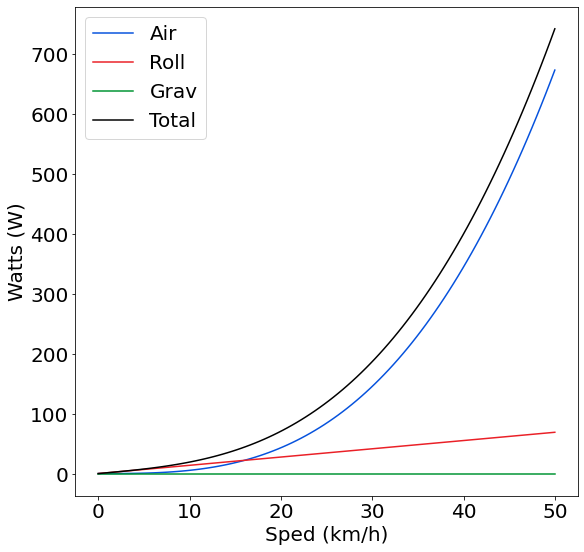

In [84]:
v = np.linspace(0,50/3.6,100)

G = 0


print('Gradient: ', G*100, '%')
print('Total weight: ', m, 'kg')
print('CdA: ', CdA)
print('Drive train efficieny: ', n*100,'%')
print('Rolling resistance: ', Crr)
print('Altitude: ', h, 'm')
print('Temperature: ', T-273, 'C')


plt.plot(v*3.6, F_air(v) * v/(n), color=blue, label='Air') # factor of 3.6 to convert from m/s to km/h
plt.plot(v*3.6, F_roll(v, G) * v/(n), color=red, label='Roll')
plt.plot(v*3.6, F_grav(v, G) * v/(n) * np.cos(np.arctan(G)), color=green, label='Grav')
plt.plot(v*3.6, calc_watts(v, G), color='black', label='Total')
# plt.title('Gradient: ' + str(G) + '%   Height: ' + str(h) + 'm   Temp: ' + str(T) + 'K')
plt.xlabel('Sped (km/h)')
plt.ylabel('Watts (W)')

plt.legend()
plt.show()

## Watts vs Sped for a range of gradients

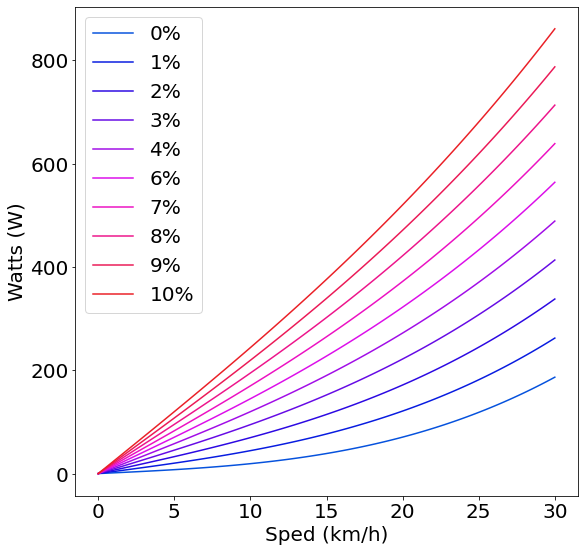

In [7]:
Gradients = np.linspace(0,0.1,10)
v = np.linspace(0,30/3.6,100)

colors = list(Color(blue).range_to(Color(red),len(Gradients)))

for x in range(len(Gradients)):
    plt.plot(v*3.6, calc_watts(v, Gradients[x]), label=str(round(Gradients[x]*100)) + '%', color=colors[x].hex)

plt.xlabel('Sped (km/h)')
plt.ylabel('Watts (W)')

plt.legend()
plt.show()

## Gradient vs Sped for a range of wattage

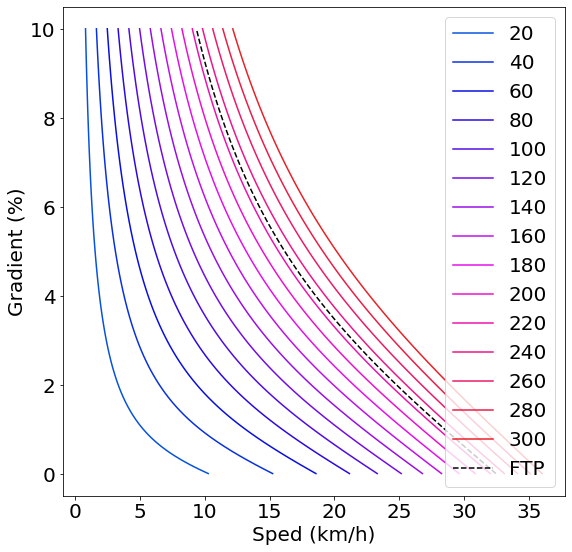

In [8]:
Wots = np.linspace(20,300,15)
Gradients = np.linspace(0,0.1,100)
colours = list(Color(blue).range_to(Color(red),len(Wots)))

# boggin way of plotting this - fix later
for x in range(len(Wots)):
    v = []
    for grad in Gradients:
        v.append(calc_sped(Wots[x], grad))
    plt.plot(np.asarray(v)*3.6, Gradients*100, color=colours[x].hex, label=round(Wots[x]))

v = []
ftp=228
for grad in Gradients:
    v.append(calc_sped(ftp, grad))
plt.plot(np.asarray(v)*3.6, Gradients*100, color='black', linestyle='--', label='FTP')
    
plt.xlabel('Sped (km/h)')
plt.ylabel('Gradient (%)')

plt.legend()
plt.show()

# How slow can you go?

In [62]:
wattCap = 200
LowestGear = 42/34
MinRPM = 30

MinSped = (MinRPM * LowestGear * np.pi * 0.7)/60
print('Min speed: ', round(MinSped*3.6,1), 'km/h')

for grad in np.linspace(0,1,1000):
    if wattCap < calc_watts(MinSped, grad):
        maxGrad = grad
        break 
        
print('Max gradient: ', round(maxGrad*100,1), '%')

Min speed:  4.9 km/h
Max gradient:  17.9 %


In [83]:
wattCap = 200
LowestGear = 42/34
RPMs = np.array([30, 60, 90])
MinSpeds = (RPMs * LowestGear * np.pi * 0.7)/60

print('For', wattCap, 'watts and a minimum gear ratio of', round(LowestGear,2))

for grad in np.linspace(0,1,1000):
    if wattCap < calc_watts(MinSped[2], grad):
        maxGrad = grad
        break      
print('\nHappy crusing: ', RPMs[2], 'rpm')
print('Min speed: ', round((RPMs[2] * LowestGear * np.pi * 0.7)/60*3.6,1), 'km/h')       
print('Max gradient: ', round(maxGrad*100,1), '%')

for grad in np.linspace(0,1,1000):
    if wattCap < calc_watts(MinSped[1], grad):
        maxGrad = grad
        break      
print('\nJust about still seated: ', RPMs[1], 'rpm')
print('Min speed: ', round((RPMs[1] * LowestGear * np.pi * 0.7)/60*3.6,1), 'km/h')       
print('Max gradient: ', round(maxGrad*100,1), '%')

for grad in np.linspace(0,1,1000):
    if wattCap < calc_watts(MinSped[0], grad):
        maxGrad = grad
        break      
print('\nStand and grind: ', RPMs[0], 'rpm')
print('Min speed: ', round((RPMs[0] * LowestGear * np.pi * 0.7)/60*3.6,1), 'km/h')       
print('Max gradient: ', round(maxGrad*100,1), '%')

For 200 watts and a minimum gear ratio of 1.24

Happy crusing:  90 rpm
Min speed:  14.7 km/h
Max gradient:  4.9 %

Just about still seated:  60 rpm
Min speed:  9.8 km/h
Max gradient:  8.3 %

Stand and grind:  30 rpm
Min speed:  4.9 km/h
Max gradient:  17.9 %
